In [1]:
from os import listdir
from os.path import isfile, join
from io import open
from time import time

import cv2
import os
import numpy as np
from random import shuffle
import imutils #need to install this with pip
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
label_list = ["Entree", "Salad", "Dessert"]

In [3]:
# Utility method to get all the images for a given label.
# For simplicity, the training and test images are origanized into folders whose name is same as the 
# label name.
def get_file_list_for_label(label):
    """
    Returns the list of files for a given label. Assumes that the images are arranged into
    folders with same name as the labels under '../Data' directory.
    """
    data_file_path = "./Data/Training/" + label
    return [join(data_file_path, f) for f in listdir(data_file_path) if isfile(join(data_file_path, f))]

In [4]:
# Constructs and returns a list of images and the corresponding labels
# The feature at this point is nothing but the image itself. Later in pre-processing,
# the image content will be reduced into features using HOG.
def get_images_and_labels():
    """
    Returns all the image contents (features), their corresponding label names as 
    two a list of tuples.
    """
    image_label_list = []
    for label in label_list:
        file_list = get_file_list_for_label(label)
        for file in file_list:
            img = cv2.imread(file)
            image_label_list.append((img, label))
    #Shuffle to randomize the data set
    shuffle(image_label_list)
    return image_label_list

In [5]:
# Initialize the hog descriptor. HOG is the utility to convert image data into numeric histogram data
minDim = 80
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9

dims = (minDim, minDim)

hog = cv2.HOGDescriptor(dims, blockSize, blockStride, cellSize, nbins)

In [6]:
# Utility method to convert list of (image, label) tuples to (HOG histogram, label) tuples
def get_hog_histograms_with_labels(image_label_list, hog, dims):
    data = []
    for img_label in image_label_list:
        # Resize images first into a fixed dimension of 80 * 80
        img = cv2.resize(img_label[0], dims)
        # Apply edge detection using Canny algorithm
        img = cv2.Canny(img,750,150)

        # Compute the HOG histogram for the edge image
        hist = hog.compute(img)
        
        data.append((hist, img_label[1]))
    shuffle(data)
    return map(list, zip(*data))

In [7]:
image_label_list = get_images_and_labels()

X, y = get_hog_histograms_with_labels(image_label_list, hog, dims)

X = [x.flatten() for x in X]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

lsvm = SVC(kernel='linear', C = 1.0, probability=True)
lsvm.fit(X, y)

#print("test accuracy ", lsvm.score(X_test, y_test))
#y_pred = lsvm.predict(X_test)
#print(classification_report(y_test, y_pred))

#print(confusion_matrix(y_test, y_pred))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

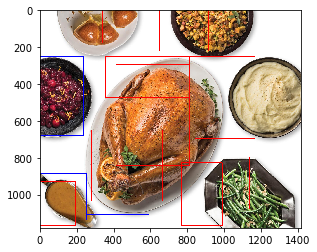

In [10]:
img = cv2.imread("Data/Test/table-4.jpg")

resized = cv2.resize(img, dims)

ratio = img.shape[0] / float(resized.shape[0])

cnts = cv2.findContours(cv2.Canny(resized,750,150), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

X_test = []
X_pos = []

for c in cnts:
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)
    
    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int((x2-x1)),int((y2-y1)))
    
    if size[0] >= 200 and size[1] >= 200:
        cropped = cv2.getRectSubPix(img, size, center)
        #plt.imshow(cropped)
        #plt.show()
        resized_crop = cv2.resize(cropped, dims)
        #plt.imshow(resized_crop)
        #plt.show()
        canny_crop = cv2.Canny(resized_crop,750,150)
        #plt.imshow(canny_crop)
        #plt.show()
        hog_crop = hog.compute(canny_crop)
        X_test.append(hog_crop.flatten())
        X_pos.append(cv2.boundingRect(c))
    
y_result = lsvm.predict(X_test);

for i in range(0, len(y_result)):
    label = y_result[i]
    bound_rect = X_pos[i]
    
    if label == 'Entree':
        color = (255, 0, 0)
    elif label == 'Salad':
        color = (0,255,0)
    elif label == 'Dessert':
        color = (0,0,255)
    
    x, y, w, h = bound_rect    
    cv2.rectangle(img, (x,y),(x+w, y+h), color, 2)    

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()    

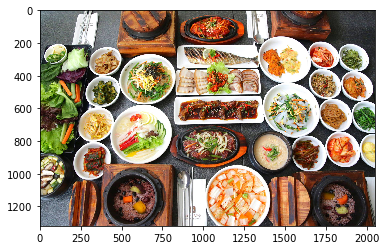

AttributeError: 'NoneType' object has no attribute 'rint'

In [12]:
import cv2
import numpy as np

plt.imshow(cv2.cvtColor(cv2.imread("Data/Test/table-4.jpg"), cv2.COLOR_BGR2RGB))
plt.show()


img = cv2.imread("Data/Test/table-4.jpg",0)
img = cv2.resize(img, dims)
#img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

#plt.imshow(img)
#plt.show()

#plt.imshow(cv2.Canny(img, 750, 150))
#plt.show()

circles = cv2.HoughCircles(cv2.Canny(img, 750, 150),cv2.HOUGH_GRADIENT,100,200,
                            param1=50,param2=30,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),10)
    # draw the center of the circle
    #cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

#plt.imshow(cimg)
#plt.show()

(1180, 1416, 3)


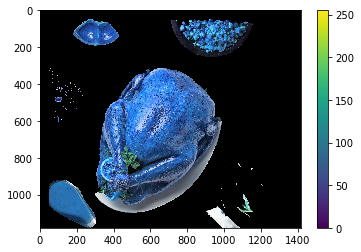

(<matplotlib.image.AxesImage at 0xd4435c0>,
 None)

In [87]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("Data/Test/table-5.jpg")
print(img.shape)
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,img.shape[0],img.shape[1])
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()

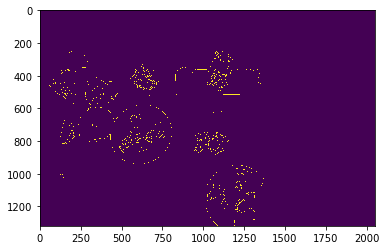

(<matplotlib.image.AxesImage at 0xd419e10>, None)

In [84]:
# newmask is the mask image I manually labelled
newmask = cv2.imread("Data/Test/table-4.jpg",0)
# whereever it is marked white (sure foreground), change mask=1
# whereever it is marked black (sure background), change mask=0
mask[newmask == 0] = 0
mask[newmask == 255] = 1
mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask[:,:,np.newaxis]
plt.imshow(cv2.Canny(img, 750, 150)),plt.show()

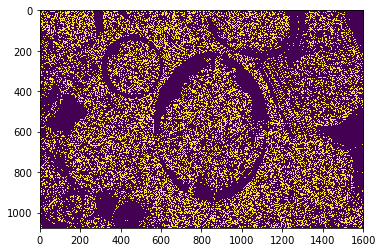

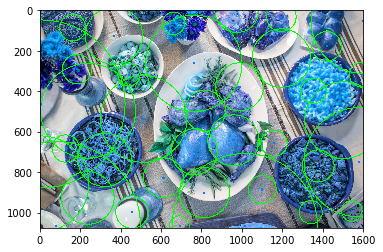

In [20]:
image = cv2.imread("Data/Test/table-6.jpg")
output = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(cv2.Canny(image,50,50))
plt.show()

# detect circles in the image
#circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2, 100)
circles = cv2.HoughCircles(cv2.Canny(image,150,150), cv2.HOUGH_GRADIENT, 2, 200, 200, 100, 50, 50)
 
# ensure at least some circles were found
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
 
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
        
plt.imshow(output)
plt.show()        

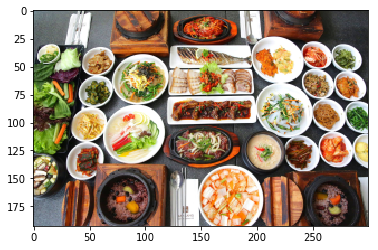

size (44, 126)
size (126, 144)
size (99, 88)
size (99, 50)
size (0, 8)
size (222, 295)


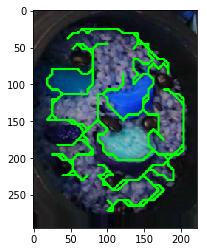

size (49, 303)
size (31, 20)
size (114, 342)
size (66, 246)
size (202, 376)


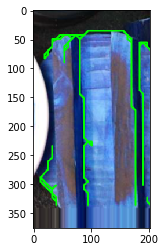

size (390, 436)


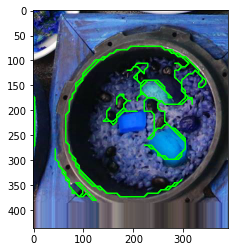

size (82, 94)
size (74, 126)
size (434, 418)


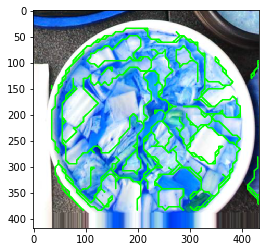

size (589, 543)


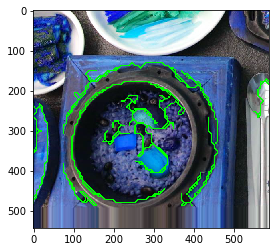

size (186, 446)


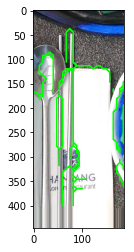

size (577, 550)


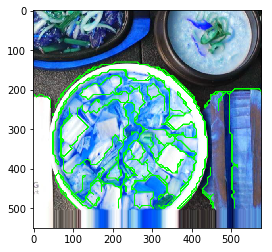

size (8, 66)
size (104, 94)
size (234, 91)
size (96, 55)
size (403, 261)


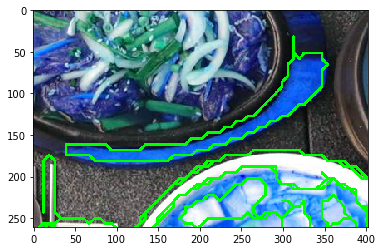

size (118, 60)
size (128, 94)
size (180, 393)


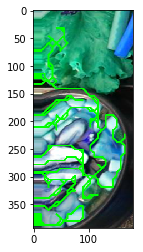

size (246, 254)


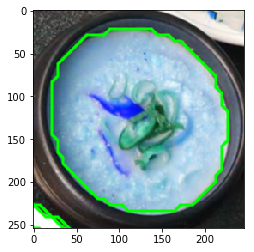

size (43, 20)
size (0, 8)
size (259, 262)


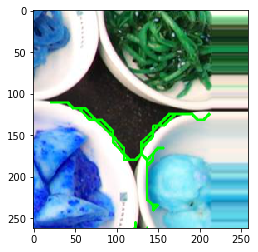

size (61, 98)
size (36, 21)
size (171, 104)
size (68, 70)
size (316, 318)


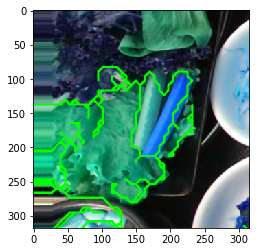

size (314, 408)


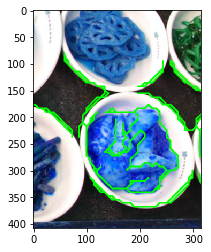

size (481, 577)


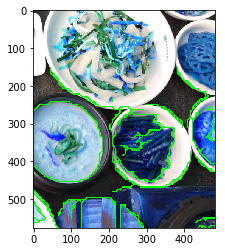

size (411, 314)


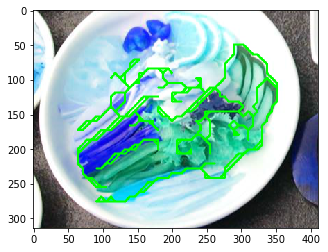

size (55, 43)
size (52, 42)
size (138, 127)
size (105, 138)
size (31, 98)
size (123, 85)
size (42, 34)
size (183, 114)
size (246, 208)


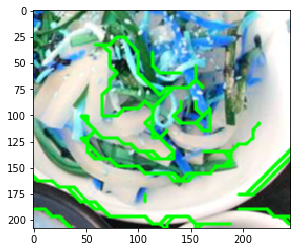

size (1200, 454)


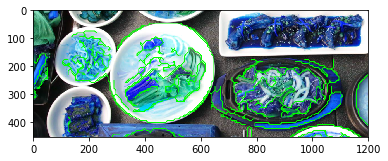

size (176, 172)


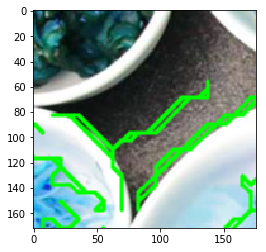

size (249, 250)


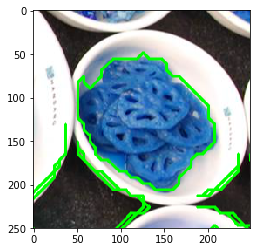

size (247, 246)


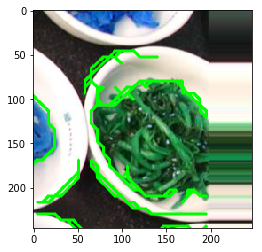

size (67, 27)
size (96, 76)
size (129, 104)
size (596, 174)


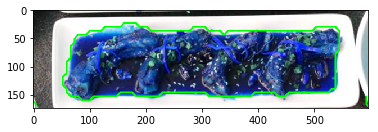

size (220, 0)
size (194, 99)
size (368, 358)


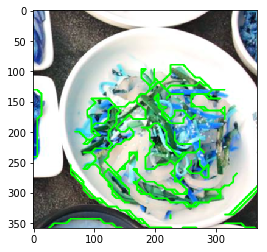

size (142, 148)
size (27, 38)
size (49, 32)
size (834, 361)


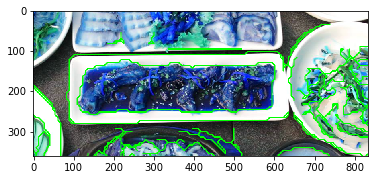

size (69, 73)
size (295, 286)


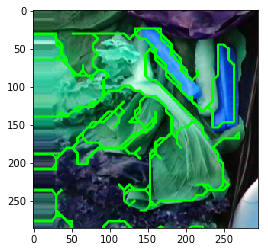

size (217, 172)


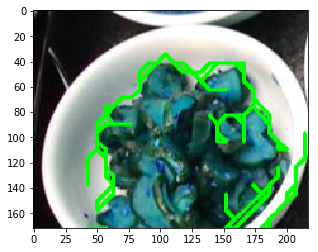

size (57, 73)
size (27, 45)
size (18, 40)
size (212, 200)


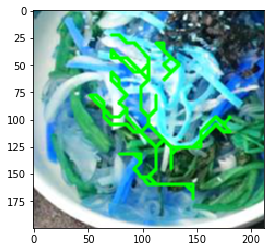

size (229, 205)


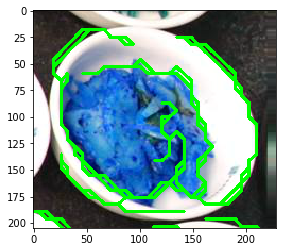

size (93, 114)
size (308, 318)


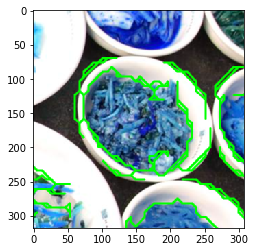

size (90, 8)
size (15, 0)
size (57, 40)
size (24, 24)
size (72, 88)
size (38, 27)
size (78, 69)
size (332, 212)


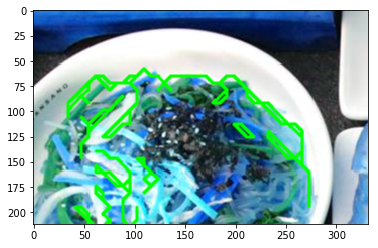

size (81, 120)
size (789, 482)


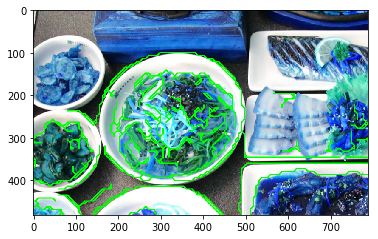

size (242, 162)


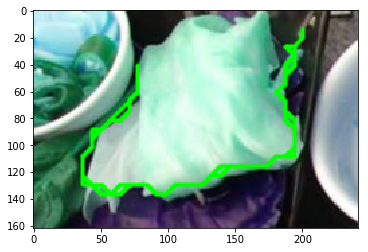

size (164, 139)
size (124, 111)
size (302, 252)


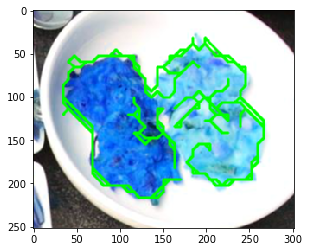

size (673, 657)


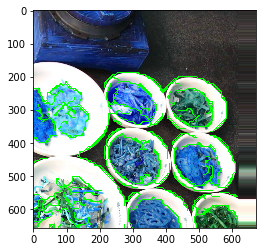

size (778, 433)


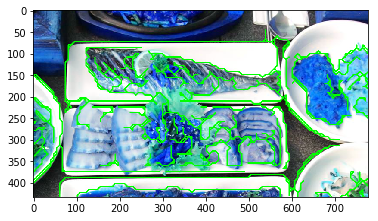

size (33, 16)
size (286, 171)


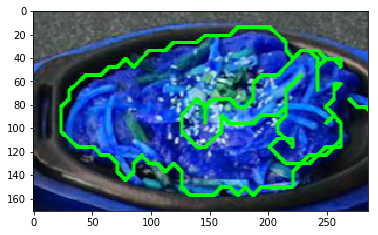

size (466, 187)


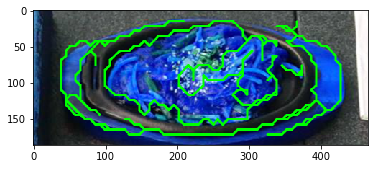

size (115, 40)
size (496, 304)


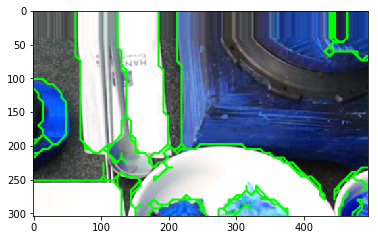

size (315, 318)


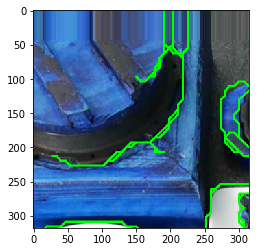

size (133, 172)
size (620, 1634)


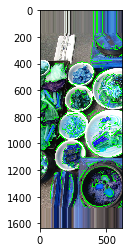

size (15, 24)
size (543, 537)


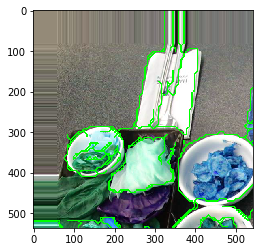

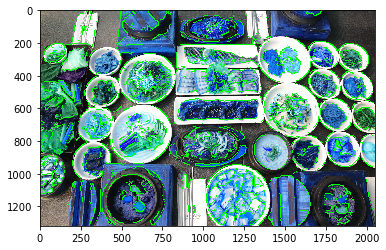

In [10]:
import cv2
import numpy as np
 
image = cv2.imread("Data/Test/table-4.jpg")
resized = imutils.resize(image, width=300)
ratio = image.shape[0] / float(resized.shape[0])
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()    
 
# convert the resized image to grayscale, blur it slightly,
# and threshold it
#gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
gray = cv2.Canny(resized,750,150)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
#plt.imshow(gray, cmap='gray')
#plt.show()
#plt.imshow(blurred, cmap='gray')
#plt.show()
#plt.imshow(thresh, cmap='gray')
#plt.show()

#plt.imshow(cv2.Canny(resized,750,150), cmap='gray')
#plt.show()
 
# find contours in the thresholded image and initialize the
# shape detector
cnts = cv2.findContours(cv2.Canny(resized,750,150), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
#sd = ShapeDetector()

# loop over the contours
for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    #M = cv2.moments(c)
    #cX = int((M["m10"] / M["m00"]) * ratio)
    #cY = int((M["m01"] / M["m00"]) * ratio)
    #shape = sd.detect(c)
 
    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape on the image
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)
    
    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int(1.2*(x2-x1)),int(1.2*(y2-y1)))
    
    print("size",size)
    
    #m2D = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

    cropped = cv2.getRectSubPix(image, size, center)    
    #cropped = cv2.warpAffine(cropped, m2D, size)
    
    #print(rect)
    
    if size[0] >= 150 and size[1] >= 150:
        plt.imshow(cropped)
        plt.show() 
 
# show the output image
plt.imshow(image)
plt.show()        